# BuidlBox Analysis

This notebook looks at historic hackathon submissions and analyzes the following:

- Who were the contributors to the repo
- How many of those contributors are already on OSO (a subset of all developers in the ecosystem)
- How many days of activity did that developer have 6 months before the hackathon / how much 6 months later / 12 months later

- An active developer is someone who committed code on 10 days in a given month
- Line chart showing active developers over 24 months period, with line showing dates of hackathon

In [1]:
from google.cloud import bigquery
import json
import os
import pandas as pd
import sys
import time
from urllib.parse import urlparse

sys.path.append(os.path.abspath("../../scripts/"))
from github import validate_github_artifact, get_owner_type, get_contributors

# Process BuidlBox data

In [2]:
# helper functions for parsing GitHub urls

def parse_url(url):
    parsed_url = urlparse(url)
    path = parsed_url.path.strip("/").split("/")
    if len(path) > 2:
        return None
    namespace =  "/".join(path).lower()
    namespace = namespace.replace(".git", "")
    if len(namespace) < 2:
        return None
    return namespace

def splitter(x, pos):
    if isinstance(x, str):
        if '/' in x:
            return x.split('/')[pos]
        elif pos == 0:
            return x
    return None

In [3]:
bb = pd.read_csv('data/gitcoin+buidlbox_data.csv')

# parse GitHub urls
bb['github_namespace'] = bb['repo_url'].apply(parse_url)
bb['github_owner'] = bb['github_namespace'].apply(lambda x: splitter(x,0))
bb['github_repo'] = bb['github_namespace'].apply(lambda x: splitter(x,1))

bb.tail()

,project_name,repo_url,created_date,hackathon_name,bounty_title,org,gitcoin/buidlbox,github_namespace,github_owner,github_repo
18518,RocketFunding,https://github.com/nijoe1/AlloHackathon,2024-01-09 01:33:19.669+00,Allo on Arbitrum Hackathon,Best use of the project registry,ArbitrumDAO,buidlbox,nijoe1/allohackathon,nijoe1,allohackathon
18519,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best use of the project registry,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface
18520,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best review and evaluation tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface
18521,Monetizado,https://github.com/monetizado/Contracts,2024-03-08 18:24:23.109+00,ALT+D(enver),Virtual Vibes & Blockchain Bytes,buidlbox,buidlbox,monetizado/contracts,monetizado,contracts
18522,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best Novel Funding Distribution Tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface


In [57]:
JSON_FILE = 'data/buidlbox_github_contributors.json'

def read_indexed_repos():

    if os.path.exists(JSON_FILE):
        with open(JSON_FILE, 'r') as jsonfile:
            return {f'{entry["owner"]}/{entry["repo"]}' for entry in json.load(jsonfile)}
    return set()

def write_contributors(contributors, mode='a'):
    if not contributors:
        return

    if os.path.exists(JSON_FILE):
        with open(JSON_FILE, 'r') as jsonfile:
            data = json.load(jsonfile)
    else:
        data = []

    for contributor in contributors:
        data.append({
            'owner': contributor[0],
            'repo': contributor[1],
            'username': contributor[2],
            'contributions': contributor[3]
        })

    with open(JSON_FILE, 'w') as jsonfile:
        json.dump(data, jsonfile, indent=2)

def process_repos(repos):
    indexed_repos = read_indexed_repos()
    for repo_key in repos:
        if not isinstance(repo_key, str): 
            continue
        if '/' not in repo_key:
            print(repo_key)
            continue
        
        owner, repo = repo_key.split('/')
        if repo_key in indexed_repos:
            print(f'Skipping already indexed repo: {repo_key}')
            continue

        contributors = get_contributors(owner, repo)
        print(contributors)
        if contributors is not None:
            write_contributors(contributors)

#process_repos(bb['github_namespace'].tail(100).unique()) 
#process_repos
process_repos(bb[bb['gitcoin/buidlbox'] == 'buidlbox']['github_namespace'].unique())

[('jpzhangvincent', 'nft-hot-pot', 'jpzhangvincent', 25), ('jpzhangvincent', 'nft-hot-pot', 'bbud148', 4)]
[('3vlinc', 'meeemor', 'danimbrogno', 48)]
[('nol13', 'buidlproject', 'sbelka-1703', 26), ('nol13', 'buidlproject', 'kaplannCC2', 23), ('nol13', 'buidlproject', 'alexandrecarvalheira', 15)]
[('jonathangus', 'swosh.cash', '0xPilou', 121), ('jonathangus', 'swosh.cash', 'jonathangus', 74), ('jonathangus', 'swosh.cash', 'Morkeeth', 8), ('jonathangus', 'swosh.cash', 'eriknson', 7)]
lifi-ethdenver2023
evmem
[('daoreaper', 'eth-denver', 'daopunk', 26), ('daoreaper', 'eth-denver', '0xRowdy', 20), ('daoreaper', 'eth-denver', 'Tconomist', 10)]
[('josephbouassaf', 'mandaexecutionethdenver', 'josephbouassaf', 1)]
[('elivasquezhdz', 'alithis-whitepaper', 'elivasquezhdz', 2)]
Error: Unable to fetch contributors (Status Code: 404)
[]
[('chainbrainstudio', 'ethdenver-buidlathon-2023', 'gosuto-inzasheru', 131), ('chainbrainstudio', 'ethdenver-buidlathon-2023', 'marissaposner', 121), ('chainbrainst

In [59]:
contributors_data = json.load(open(JSON_FILE, "r"))
contributors_df = pd.DataFrame(contributors_data)
contributors_df['username'].value_counts()

print(contributors_df['username'].nunique())
contributors_list = [c.lower() for c in contributors_df['username'].unique()
                     if '[bot]' not in c and c.lower() not in 'metamaskbot']
len(contributors_list)

4680


4668

In [93]:
relevant_githubs = bb[bb['created_date'] >= "2022-01-01"]['github_namespace'].unique()
process_repos(relevant_githubs)

Skipping already indexed repo: inosgun/ghn
bocoi5011
Skipping already indexed repo: jiuhong-casperlabs/eip3156workspace
Skipping already indexed repo: mopdo/piratesjustar
Skipping already indexed repo: mearaj/blockchain-inbox
Skipping already indexed repo: satoshinakamoto007/bitcoin-bitcoin
Error: Unable to fetch contributors (Status Code: 404)
[]
Skipping already indexed repo: misterplus/discourse-plugin-snapshot
Error: Unable to fetch contributors (Status Code: 404)
[]
[('subquery', 'subql', 'jiqiang90', 1028), ('subquery', 'subql', 'stwiname', 676), ('subquery', 'subql', 'bz888', 244), ('subquery', 'subql', 'ianhe8x', 202), ('subquery', 'subql', 'guplersaxanoid', 108), ('subquery', 'subql', 'fishmonger45', 57), ('subquery', 'subql', 'lamcc21', 52), ('subquery', 'subql', 'jamesbayly', 40), ('subquery', 'subql', 'yoozo', 39), ('subquery', 'subql', 'dependabot[bot]', 38), ('subquery', 'subql', 'zhex', 26), ('subquery', 'subql', 'bighammerw', 12), ('subquery', 'subql', 'spitko', 8), ('s

In [90]:
contributors_df['github_namespace'] = contributors_df['owner'] + '/' + contributors_df['repo']
filtered_contributors_df = contributors_df[contributors_df['github_namespace'].isin(relevant_githubs)]
filtered_contributors_df

,owner,repo,username,contributions,github_namespace
40,gitcoinco,web,owocki,7400,gitcoinco/web
41,gitcoinco,web,thelostone-mc,2675,gitcoinco/web
42,gitcoinco,web,octavioamu,1778,gitcoinco/web
43,gitcoinco,web,mbeacom,1236,gitcoinco/web
44,gitcoinco,web,danlipert,553,gitcoinco/web
...,...,...,...,...,...
8482,klitchka,memespark,klitchka,3,klitchka/memespark
8483,klitchka,memespark,dolvin17,2,klitchka/memespark
8484,theexpandingpolytope,nes3,lynoferraz,20,theexpandingpolytope/nes3
8485,theexpandingpolytope,nes3,TheExpandingPolytope,1,theexpandingpolytope/nes3


In [91]:
contributors_list = [c.lower() for c in filtered_contributors_df['username'].unique()
                     if '[bot]' not in c and c.lower() not in 'metamaskbot']
len(contributors_list)

704

In [92]:
contributors_str = "'" + "','".join(contributors_list)  + "'"

In [72]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../gcp_credentials.json'
client = bigquery.Client()
PROJECT = 'opensource-observer'

In [73]:
query = f"""
SELECT
    time,
    event_type,
    from_artifact_name,
    to_artifact_namespace,
    to_artifact_name
FROM `{PROJECT}.oso.int_events_github`
WHERE
    from_artifact_name in ({contributors_str})
    AND event_type in ('COMMIT_CODE', 'PULL_REQUEST_OPENED', 'ISSUE_OPENED')
"""

result = client.query(query)
contributor_graph = result.to_dataframe()
contributor_graph['month'] = contributor_graph['time'].dt.strftime('%Y-%m')
contributor_graph['date'] = contributor_graph['time'].dt.strftime('%Y-%m-%d')

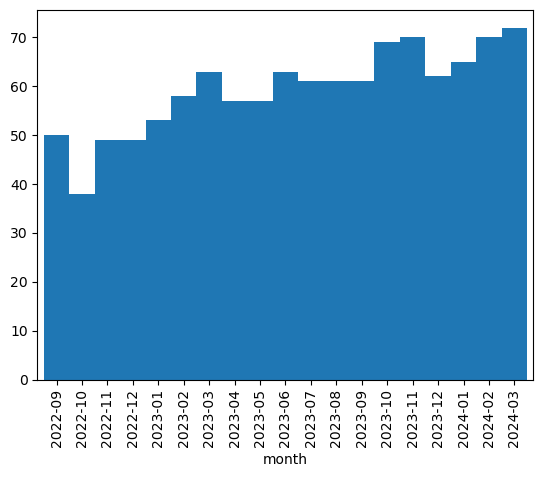

In [83]:
relevant_contributor_graph = contributor_graph[(contributor_graph['month'] >= '2022-09') & (contributor_graph['month'] < '2024-04')] 
contributor_activity = relevant_contributor_graph.groupby(['from_artifact_name', 'month'])['date'].nunique().reset_index()
active_contributors = contributor_activity[contributor_activity['date']>=5].groupby('month')['from_artifact_name'].nunique()
f = active_contributors.plot(kind='bar', width=1)

In [86]:
contributor_activity.groupby('from_artifact_name')['date'].mean().sort_values().tail(20)

from_artifact_name
jmoreira-valory    12.157895
protolambda        12.157895
sin-bufan          12.285714
technophile-04     12.842105
roninjin10         12.894737
clabby             13.000000
friendlysxw        13.307692
tonyce             13.571429
refcell            13.600000
omahs              13.833333
carletex           13.894737
adamantios         14.105263
codenamejason      14.894737
angrybayblade      15.894737
samholmes          16.526316
tynes              16.736842
davidminarsch      17.052632
ajsutton           18.052632
sasicodes          26.052632
bigint             28.894737
Name: date, dtype: float64

In [36]:
bb[bb['created_date'] >= '2022-0101']['hackathon_name'].value_counts()

,project_name,repo_url,created_date,hackathon_name,bounty_title,org,gitcoin/buidlbox,github_namespace,github_owner,github_repo
16157,[AT4] - NFT Hot Pot,https://github.com/jpzhangvincent/nft-hot-pot,2023-03-02 20:40:52.788+00,ETHDenver 2023,Deploy a decentralized frontend component for ...,NEAR,buidlbox,jpzhangvincent/nft-hot-pot,jpzhangvincent,nft-hot-pot
16158,Meeemor,https://github.com/3VLINC/meeemor,2023-03-03 21:37:49.948+00,ETHDenver 2023,Web3Modal Creative Challenge,Wallet Connect,buidlbox,3vlinc/meeemor,3vlinc,meeemor
16159,[AG3] - Sofamon,https://github.com/orgs/Sofamon/repositories,2023-03-05 03:48:10.073+00,ETHDenver 2023,Cypher Onboarding SDK,Cypher Wallet,buidlbox,None,None,None
16160,[O3] - Optino,https://github.com/yielddev/ETHDenver-Optino/t...,2023-02-25 02:28:18.634+00,ETHDenver 2023,Integrate Tenderly Web3 Gateway,Tenderly,buidlbox,None,None,None
16161,[K8] - WritersBlock,https://github.com/nol13/BuidlProject,2023-03-04 01:04:48.275+00,ETHDenver 2023,#BUIDLathon 2023 DAOs + Community Track,ETHDenver,buidlbox,nol13/buidlproject,nol13,buidlproject
...,...,...,...,...,...,...,...,...,...,...
18518,RocketFunding,https://github.com/nijoe1/AlloHackathon,2024-01-09 01:33:19.669+00,Allo on Arbitrum Hackathon,Best use of the project registry,ArbitrumDAO,buidlbox,nijoe1/allohackathon,nijoe1,allohackathon
18519,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best use of the project registry,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface
18520,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best review and evaluation tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface
18521,Monetizado,https://github.com/monetizado/Contracts,2024-03-08 18:24:23.109+00,ALT+D(enver),Virtual Vibes & Blockchain Bytes,buidlbox,buidlbox,monetizado/contracts,monetizado,contracts


In [ ]:

# analyze repos
bb['is_valid_github_url'] = bb['repo_url'].str.contains("github.com/")
bb['is_valid_github_namespace'] = bb['github_namespace'].apply(lambda x: isinstance(x, str))
bb['does_owner_have_project_on_oso'] = bb['github_owner'].apply(lambda x: x in existing_orgs)
bb['is_repo_on_oso'] = bb['github_namespace'].apply(lambda x: x in existing_repos)

bb.head(3)

In [24]:
len(bb[bb.created_date > '2019-01-01'])
bb.created_date.min()

'2019-11-07 19:23:37+00'

In [10]:
bb[bb.columns[-4:]].mean()

is_valid_github_url               0.993522
is_valid_github_namespace         0.775522
does_owner_have_project_on_oso    0.018464
is_repo_on_oso                    0.010797
dtype: float64

# Query latest OSO project data

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../gcp_credentials.json'
client = bigquery.Client()

In [7]:
query = """
SELECT DISTINCT project_id, project_name, artifact_name 
FROM `opensource-observer.oso.artifacts_by_project_v1`
WHERE artifact_source = 'GITHUB'
"""

result = client.query(query)
project_artifacts = result.to_dataframe()
project_artifacts.tail(3)

,project_id,project_name,artifact_name
49183,wYkEZp0T0rnjK8mgkbyCVPX6KkyP17-hSxc8IeJalpA=,code-423n4,2023-10-asymmetry-mitigation
49184,wYkEZp0T0rnjK8mgkbyCVPX6KkyP17-hSxc8IeJalpA=,code-423n4,2023-09-maia-findings
49185,wYkEZp0T0rnjK8mgkbyCVPX6KkyP17-hSxc8IeJalpA=,code-423n4,2023-11-betafinance-findings


In [8]:
existing_repos = list(project_artifacts['artifact_name'].unique())
len(existing_repos)

40305

In [9]:
existing_orgs = list(set([x.split('/')[0] for x in existing_repos]))
len(existing_orgs)

40305

# Lookup whether project is User or Org

In [11]:
bb_owners = list(bb['github_owner'].dropna().unique())
len(bb_owners)

4780

In [12]:
def process_owners(list_of_owners, json_path, sleep=1):
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            results = json.load(f)
    else:
        results = {}
    
    for x in list_of_owners:
        if x in results:
            continue
        outcome = get_owner_type(x)
        results.update({x:outcome})        
        with open(json_path, 'w') as f:
            json.dump(results, f, indent=2)
        time.sleep(sleep)
        
    return results
    
github_checks_path = 'data/github_owners.json'    
github_owners = process_owners(
    bb_owners, 
    github_checks_path,
    sleep=0
)    

In [13]:
bb['github_owner_type'] = bb['github_owner'].map(github_owners)
bb.tail(3)

,project_name,repo_url,created_date,hackathon_name,bounty_title,org,gitcoin/buidlbox,github_namespace,github_owner,github_repo,is_valid_github_url,is_valid_github_namespace,does_owner_have_project_on_oso,is_repo_on_oso,github_owner_type
18520,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best review and evaluation tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface,True,True,False,False,Organization
18521,Monetizado,https://github.com/monetizado/Contracts,2024-03-08 18:24:23.109+00,ALT+D(enver),Virtual Vibes & Blockchain Bytes,buidlbox,buidlbox,monetizado/contracts,monetizado,contracts,True,True,False,False,Organization
18522,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best Novel Funding Distribution Tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface,True,True,False,False,Organization


# Check whether user is contributing to other projects on OSO

In [14]:
bb_users_on_oso = (
    set(bb[bb['github_owner_type'] == 'User']['github_owner'].unique())
    .intersection(set(existing_users))
)
len(bb_users_on_oso)

2079

In [15]:
project_users_on_bb = (
    project_users[project_users['user_name'].isin(bb_users_on_oso)]
    .groupby('user_name')
    .agg(
        {
            'date_last_activity': max,
            'project_id': 'nunique'
        }
    )
)
project_users_on_bb

,date_last_activity,project_id
user_name,,
00x-dx,2024-01-30 16:20:29+00:00,2
0101coding,2022-08-08 18:37:03+00:00,1
0xandrew,2022-04-11 18:54:35+00:00,1
0xb0x,2022-06-07 19:41:50+00:00,2
0xbeedao,2022-03-28 23:58:38+00:00,4
...,...,...
zpencerguy,2023-07-14 23:01:06+00:00,8
zvezdochetag,2023-11-17 15:21:45+00:00,11
zyfrank,2021-06-18 00:40:07+00:00,16


In [16]:
bb_recent_users_on_oso = list(project_users_on_bb[project_users_on_bb['date_last_activity'] >= '2024-01-01'].index)
len(bb_recent_users_on_oso)

512

In [17]:
bb['is_user_visible_on_oso'] = bb['github_owner'].apply(lambda x: x in bb_users_on_oso)
bb['is_user_active_recently_on_oso'] = bb['github_owner'].apply(lambda x: x in bb_recent_users_on_oso)

bb.tail(3)

,project_name,repo_url,created_date,hackathon_name,bounty_title,org,gitcoin/buidlbox,github_namespace,github_owner,github_repo,is_valid_github_url,is_valid_github_namespace,does_owner_have_project_on_oso,is_repo_on_oso,github_owner_type,is_user_visible_on_oso,is_user_active_recently_on_oso
18520,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best review and evaluation tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface,True,True,False,False,Organization,False,False
18521,Monetizado,https://github.com/monetizado/Contracts,2024-03-08 18:24:23.109+00,ALT+D(enver),Virtual Vibes & Blockchain Bytes,buidlbox,buidlbox,monetizado/contracts,monetizado,contracts,True,True,False,False,Organization,False,False
18522,PledgePost,https://github.com/PledgePost/v2Interface,2023-12-26 11:37:31.15+00,Allo on Arbitrum Hackathon,Best Novel Funding Distribution Tool,ArbitrumDAO,buidlbox,pledgepost/v2interface,pledgepost,v2interface,True,True,False,False,Organization,False,False


# Get GitHub info for projects not on OSO

In [18]:
bb_potential_artifacts = list(
    bb[bb['does_owner_have_project_on_oso'] == False]
    ['github_namespace'].dropna().unique()
)
len(bb_potential_artifacts)

8843

In [19]:
def process_github(list_of_artifacts, json_path, sleep=1):
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            results = json.load(f)
    else:
        results = {}
    
    for a in list_of_artifacts:
        if a in results:
            continue
        outcome = validate_github_artifact(a)
        results.update({a:outcome})        
        with open(json_path, 'w') as f:
            json.dump(results, f, indent=2)
        time.sleep(sleep)
        
    return results
    
github_checks_path = 'data/github_checks.json'    
github_results = process_github(
    bb_potential_artifacts, 
    github_checks_path,
    sleep=0
)    

In [20]:
bb['is_valid_new_project'] = bb['github_namespace'].apply(
    lambda x: github_results.get(x, {'Approved': False})['Approved'])

bb['project_status_notes'] = bb['github_namespace'].apply(
    lambda x: github_results.get(x, {'Reason': None})['Reason'])

In [21]:
bb['is_repo_still_available'] = (
    (bb['is_valid_github_namespace'] == True)
    & (bb['project_status_notes'] != 'Repo no longer available.')
)

In [22]:
test_cols = [c for c in bb.columns if c.split('_')[0] in ['is', 'does']]
bb[test_cols].mean()

is_valid_github_url               0.993522
is_valid_github_namespace         0.775522
does_owner_have_project_on_oso    0.018464
is_repo_on_oso                    0.010797
is_user_visible_on_oso            0.418777
is_user_active_recently_on_oso    0.115316
is_valid_new_project              0.007504
is_repo_still_available           0.574313
dtype: float64

# Export snapshot of data

In [23]:
bb.to_csv('data/oso_bb_analysis.csv')

# Print projects to add to OSO

In [24]:
potential_projects = sorted(bb[bb['is_valid_new_project'] == True]['github_namespace'].unique())
for p in potential_projects:
    print(f"- https://github.com/{p}")

- https://github.com/0xchijioke/pooldive
- https://github.com/agoraspacedao/guild.xyz
- https://github.com/akord-com
- https://github.com/alexandr-masl/web3-crowdfunding-on-allo-v2
- https://github.com/alexandre-abrioux/golem-node
- https://github.com/algorand/go-algorand-sdk
- https://github.com/alloliance
- https://github.com/anudit/convo
- https://github.com/bitcoin
- https://github.com/castvell/sperax-auditory-report
- https://github.com/ceramicnetwork/ceramic
- https://github.com/cheqlabs/denota
- https://github.com/cryptonerdcn/wasm-cairo
- https://github.com/dapotatoman/tez-it-all
- https://github.com/defitrack/defitrack-core
- https://github.com/dimensiondev/maskbook
- https://github.com/ebridgecrosschain
- https://github.com/elimu-ai
- https://github.com/ensuro/ensuro-binancehackathon
- https://github.com/farque65/evmaddresstracker
- https://github.com/flowstake
- https://github.com/g-r-ay/arbitrum-qa-dashboard
- https://github.com/harmony-one
- https://github.com/harmony-one/